In [1]:
# Data manipulation
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf

# Dealing with temporal data
from typing import Dict, List, Tuple, Sequence

# Tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

2023-03-10 12:15:01.705348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 12:15:01.808125: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 12:15:01.812815: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 12:15:01.812829: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [29]:
os.getcwd()

csv_path = os.path.join('..', 'inflation-forecasting', 'raw_data')

df = pd.read_csv(os.path.join(csv_path,'data_final.csv'), index_col=0)

In [30]:
df['year'] = pd.to_datetime(df['year'])

In [33]:
df_us = df[df['country_id'] == "USA"]

In [34]:
df_us.shape

(757, 10)

In [35]:
ccpi = pd.DataFrame(df_us['ccpi'])

In [36]:
ccpi = ccpi.to_numpy()

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ccpi.reshape(-1,1))

In [38]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [39]:
n_steps_in = 12

data = dataset[0:]

X, Y = split_sequence(data, n_steps_in)

In [40]:
X.shape

(745, 12, 1)

In [41]:
n_features = X.shape[2]

uni_model = models.Sequential()
uni_model.add(LSTM(64, input_shape=(X.shape[1], n_features))) # Adding the LSTM layer
uni_model.add(Dense(1))

In [42]:
adam = optimizers.Adam(learning_rate=0.02) 

uni_model.compile(loss='mse', 
                  optimizer=adam, 
                  metrics=["mse"])

In [43]:
fit = uni_model.fit(X, 
                    Y,   
                    epochs = 25, 
                    batch_size=1,
                    verbose = 1)

Epoch 1/25
745/745 [==============================] - 3s 3ms/step - loss: 0.0031 - mse: 0.0031
Epoch 2/25
745/745 [==============================] - 2s 3ms/step - loss: 0.0011 - mse: 0.0011
Epoch 3/25
745/745 [==============================] - 2s 3ms/step - loss: 0.0016 - mse: 0.0016
Epoch 4/25
745/745 [==============================] - 2s 3ms/step - loss: 0.0010 - mse: 0.0010  
Epoch 5/25
745/745 [==============================] - 2s 3ms/step - loss: 9.5596e-04 - mse: 9.5596e-04
Epoch 6/25
745/745 [==============================] - 2s 3ms/step - loss: 9.9294e-04 - mse: 9.9294e-04
Epoch 7/25
745/745 [==============================] - 2s 3ms/step - loss: 8.9995e-04 - mse: 8.9995e-04
Epoch 8/25
745/745 [==============================] - 2s 3ms/step - loss: 0.0011 - mse: 0.0011   
Epoch 9/25
745/745 [==============================] - 2s 3ms/step - loss: 8.2213e-04 - mse: 8.2213e-04
Epoch 10/25
745/745 [==============================] - 2s 3ms/step - loss: 8.6506e-04 - mse: 8.6506e-04
Epoc

<function matplotlib.pyplot.show(close=None, block=None)>

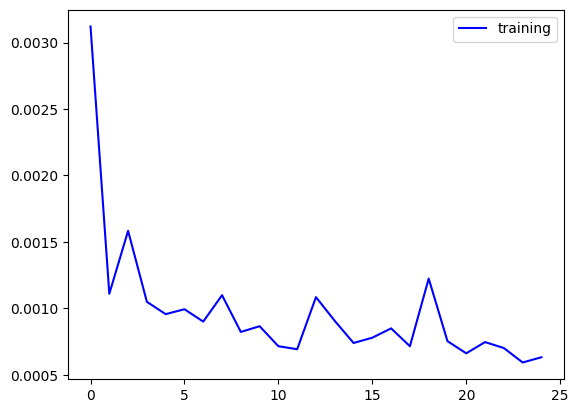

In [44]:
# Check for overfitting
plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
#plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
plt.legend()
plt.show

In [45]:
X.shape

(745, 12, 1)

In [46]:
Predict = uni_model.predict(X)

Y_hat = scaler.inverse_transform(Predict)

Y_actual = scaler.inverse_transform(Y)



24/24 [==============================] - 0s 2ms/step


In [47]:
data1 = pd.DataFrame(Y_actual)
data2 = pd.DataFrame(Y_hat)

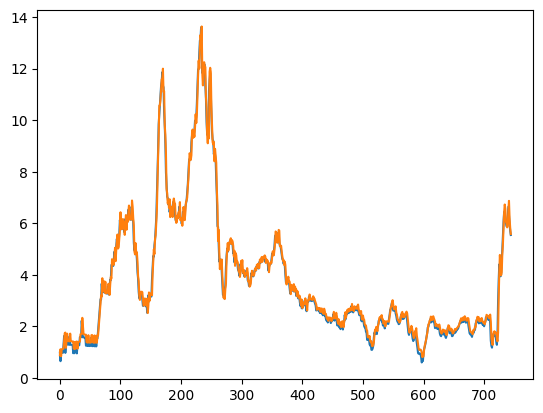

In [48]:
plt.plot(data1)
plt.plot(data2);

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
trainScore = mean_squared_error(Ytrain_actual, Ytrain_hat[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(Ytest_actual, Ytest_hat[:,0])
print('Test Score: %.2f MSE' % (testScore))
model_error = Ytest_actual - Ytest_hat[:,0]
print('Mean Model Error: ', model_error.mean())

Train Score: 0.08 MSE
Test Score: 0.33 MSE
Mean Model Error:  0.03589827897756006


In [49]:
n_steps_in = 12
x_input = np.array(dataset[-12:])
x_input = x_input.reshape((1, n_steps_in, n_features))
forecast_normalized = uni_model.predict(x_input)
forecast = scaler.inverse_transform(forecast_normalized)

1/1 [==============================] - 0s 14ms/step


In [50]:
pd.DataFrame(forecast)

,0
0,5.470653


In [29]:
# Make a prediction
# Append the predition
# Shift the data
# Fit the model again
# Repeat ...
# Normalize invert